In [39]:
%load_ext autoreload
%autoreload 2
import numpy as np
import statmorph_joint
from segmap import get_segmap
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import cmasher
import sep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in an example source
- z-band image and variance
- ha image and variance
- psf of z band (both images are convolved to share this PSF)

In [2]:
merids = np.unique([i.split("/")[1].split("_")[0] for i in glob.glob("example_images/*.fits")])

merid = merids[7]
image_ha = fits.open(f"example_images/{merid}_ha.fits")[1].data
image_z  = fits.open(f"example_images/{merid}_z.fits")[1].data
psf      = fits.open(f"example_images/{merid}_psf.fits")[0].data

var_ha = fits.open(f"example_images/{merid}_ha.fits")[2].data
var_z = fits.open(f"example_images/{merid}_z.fits")[2].data


# Get the segmentation map and mask
- I'm using `sep` but you can use whatever you prefer and tweak the thresholds, etc.
- The mask masks out all other identified sources.

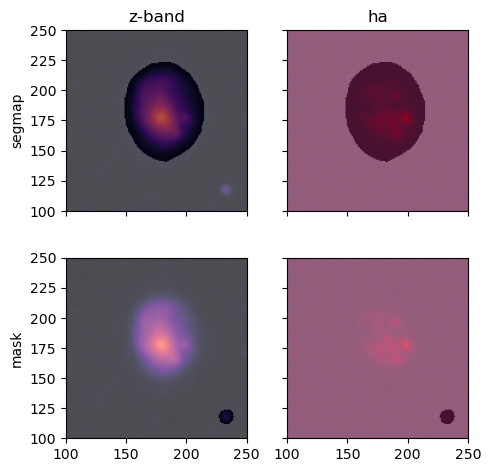

In [41]:
segmap, mask = get_segmap(image_z, psf)
ha_bkg = sep.Background(image_ha.astype(image_ha.dtype.newbyteorder('='))) # weird byteswap issue
z_bkg = sep.Background(image_z.astype(image_z.dtype.newbyteorder('='))) # weird

fig, ax = plt.subplots(2, 2, figsize = (5,5), sharex=True, sharey=True)
[a.imshow(image_z, norm = colors.AsinhNorm(),cmap="magma") for a in ax[:,0]]
[a.imshow(image_ha, norm = colors.AsinhNorm(),cmap="cmr.ember") for a in ax[:,1]]
[a.imshow(segmap, cmap="Greys", alpha=0.3) for a in ax[0]]
[a.imshow(mask, cmap="Greys", alpha=0.3) for a in ax[1]]
[a.set_title(t) for a, t in zip(ax[0], ["z-band", "ha"])]
[a.set_ylabel(t) for a, t in zip(ax[:,0], ["segmap", 'mask'])]

ax[0,0].set_xlim(100,250); ax[0,0].set_ylim(100,250)

fig.tight_layout()

# Calculate the morphology
- First of z and ha separately, using original `statmorph` function
- Then with ha fixed to z-band using `statmorph_joint`

In [4]:
# plotting function from original statmorph
# to make this work, you need to comment out lines 41 and 42 of image_diagnostics.py 
# in the original statmorph package because the new object is not of the same type
from statmorph.utils.image_diagnostics import make_figure

In [42]:
morph_z = statmorph_joint.source_morphology(image_z - z_bkg, segmap, weightmap=var_z**.5, mask = mask)[0]
morph_ha = statmorph_joint.source_morphology(image_ha - ha_bkg, segmap, weightmap=var_ha**.5, mask = mask)[0]
morph_joint = statmorph_joint.source_morphology_joint([image_z - z_bkg, image_ha - ha_bkg], segmap, weightmaps=[var_z**.5, var_ha**.5], mask = mask)

## Look at the results using the `statmorph` `make_figure` function`

[<Figure size 1620x884 with 8 Axes>,
 <Figure size 1620x884 with 8 Axes>,
 <Figure size 1620x884 with 8 Axes>]

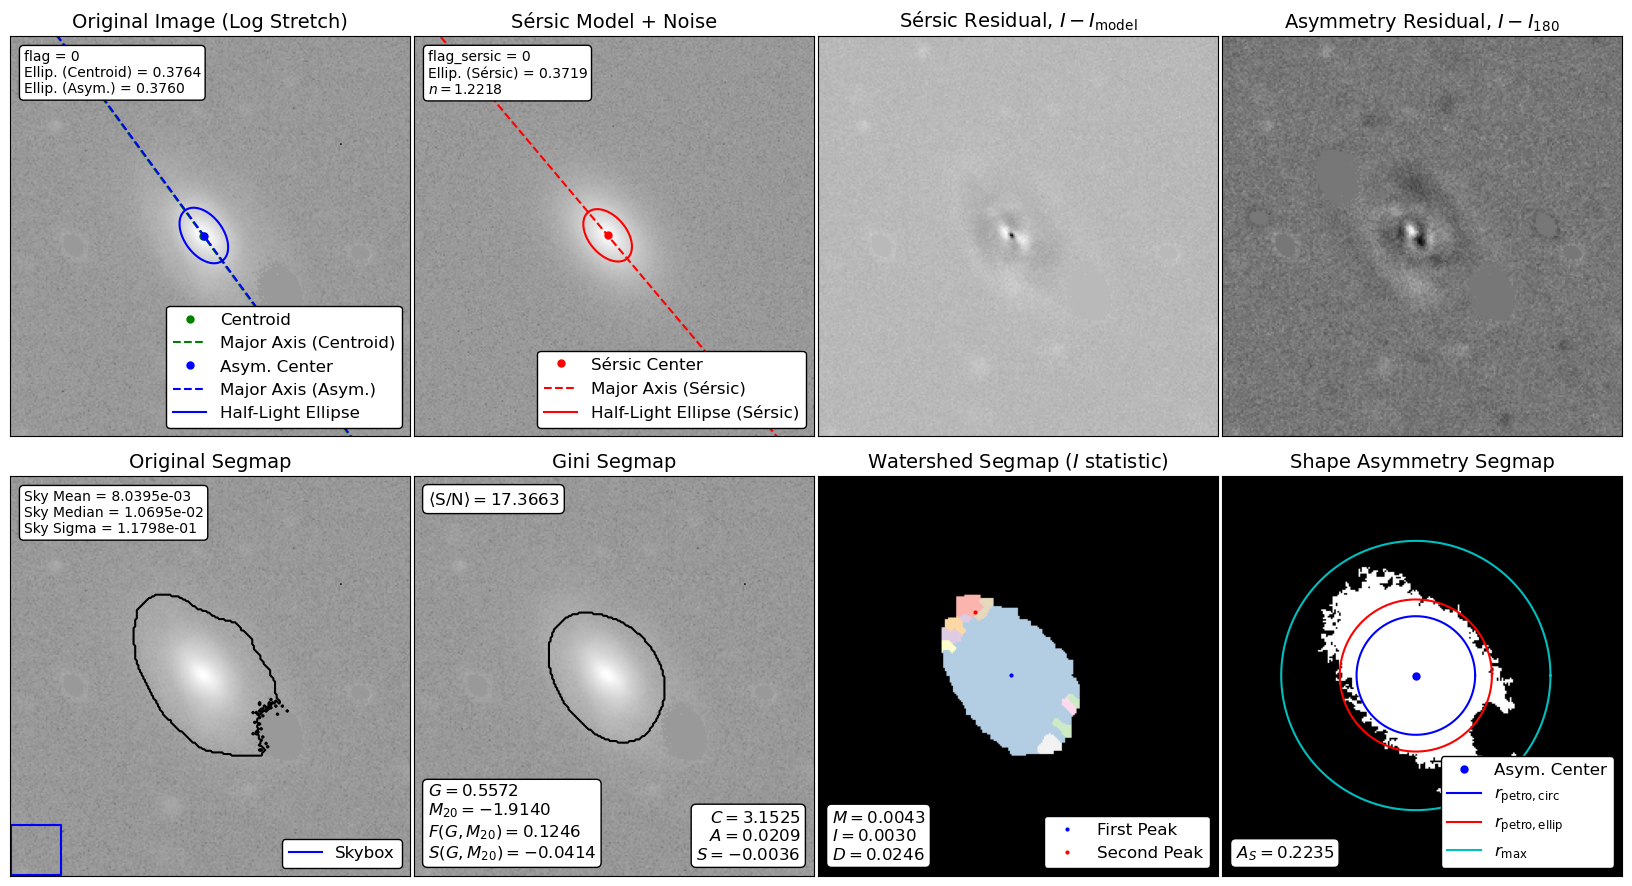

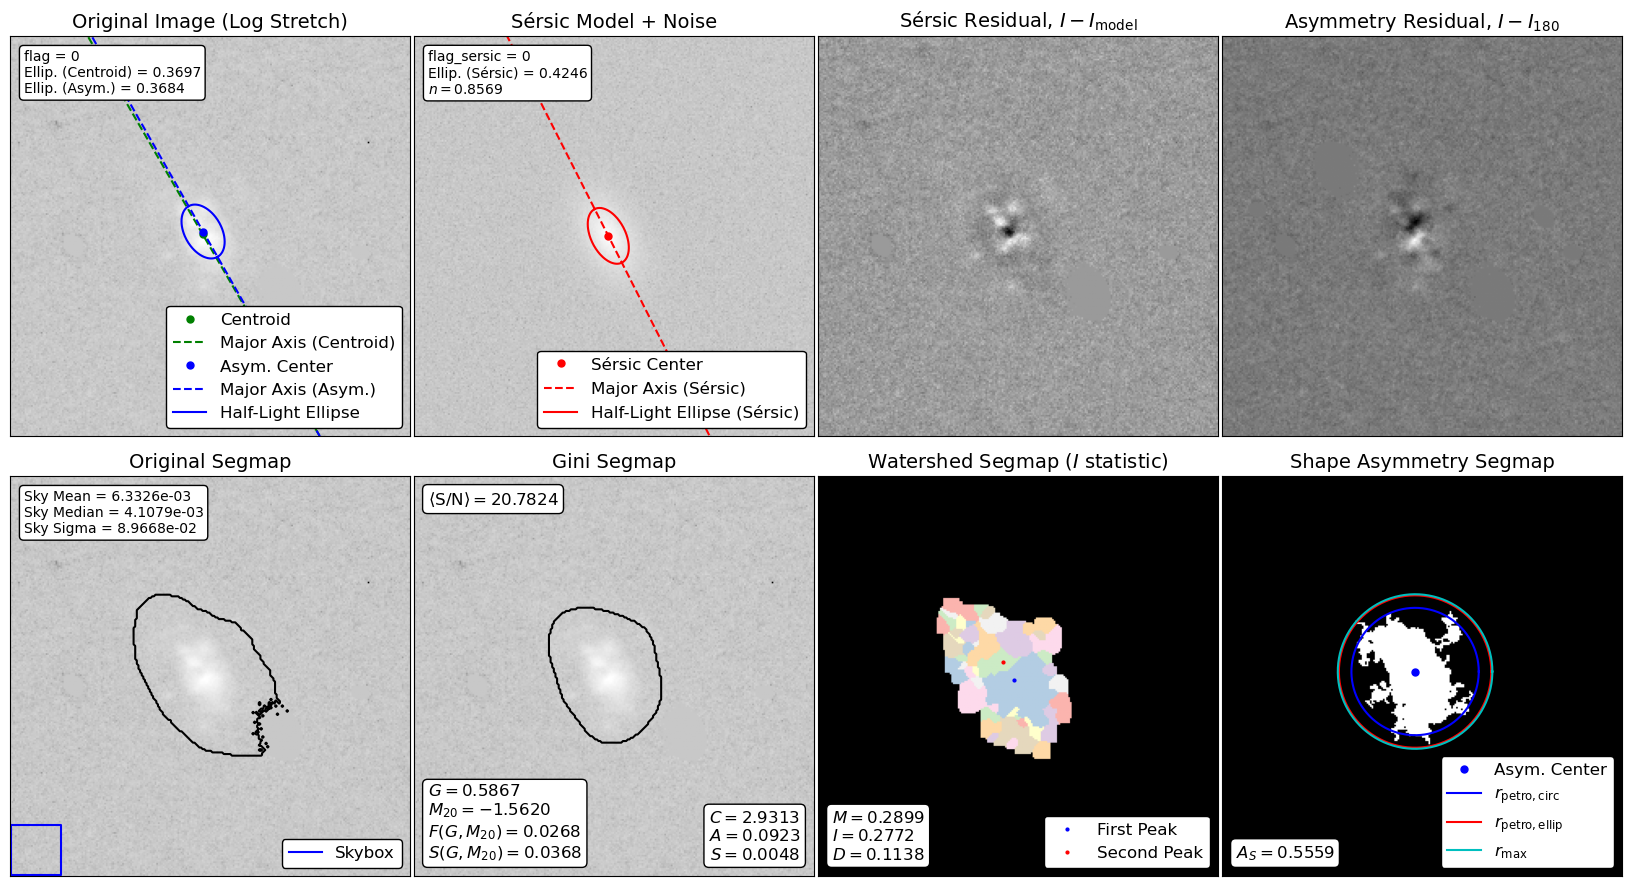

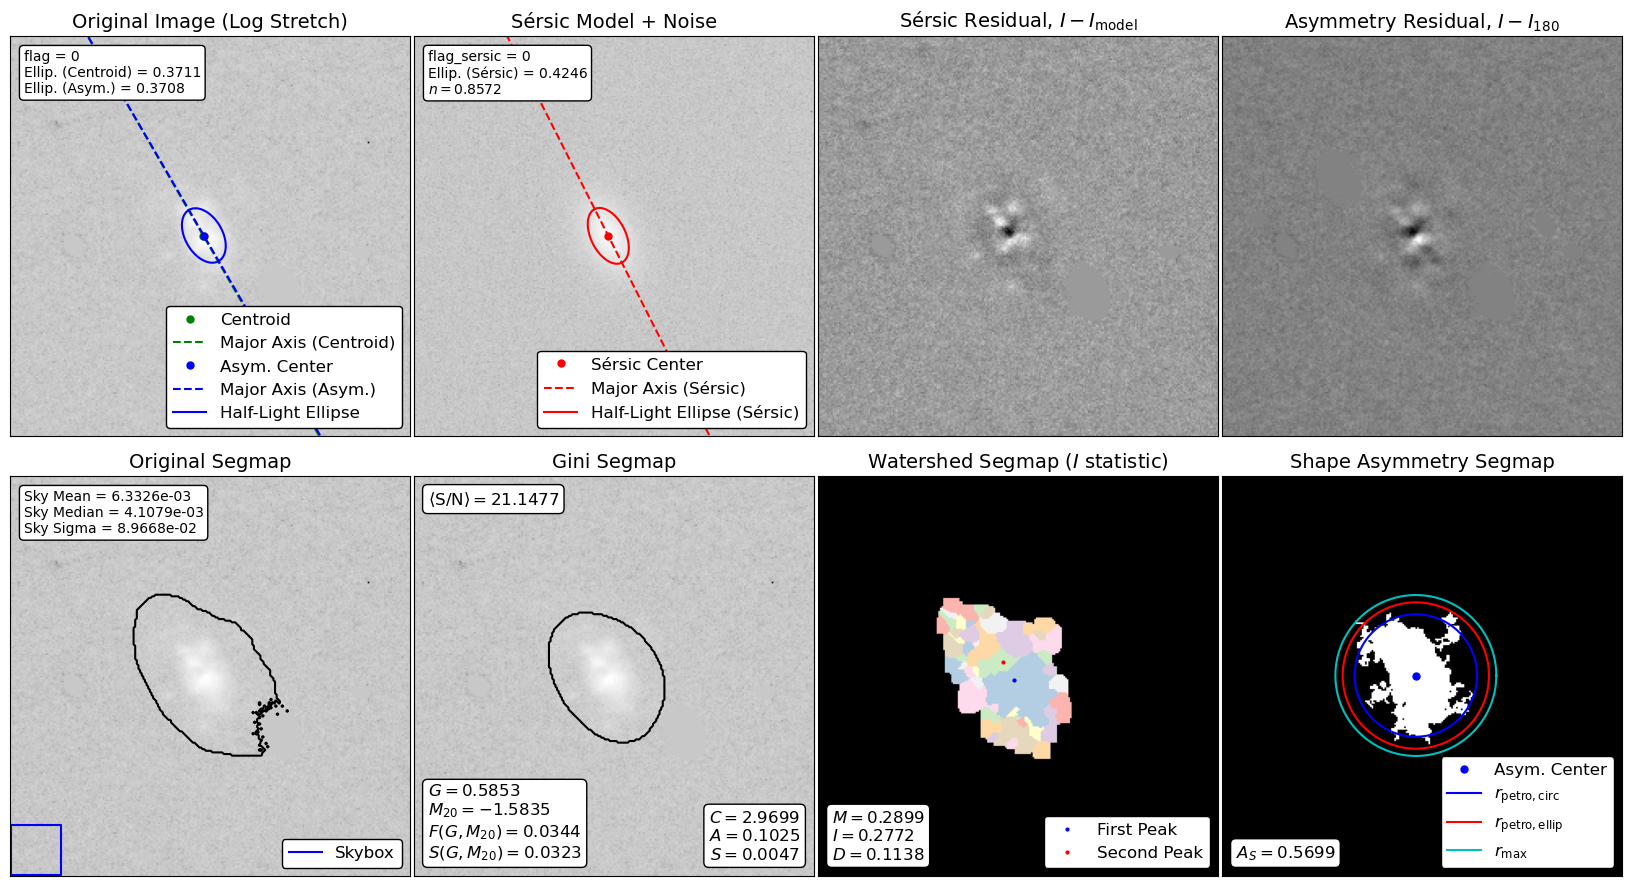

In [6]:
[make_figure(m) for m in [morph_z, morph_ha, morph_joint[1]]]

## Or use this function to vizualize the difference in centers and calculated morphologies 

In [7]:
def compare_morphs(morph_z, morph_ha, morph_joint, zoom = 100):

    zoom = 100
    image_z_plot = morph_z._image.copy()
    image_z_plot[:zoom, :] = np.nan
    image_z_plot[-zoom:, :] = np.nan
    image_z_plot[:, :zoom] = np.nan
    image_z_plot[:, -zoom:] = np.nan

    image_ha_plot = morph_ha._image.copy()
    image_ha_plot[:zoom, :] = np.nan
    image_ha_plot[-zoom:, :] = np.nan
    image_ha_plot[:, :zoom] = np.nan
    image_ha_plot[:, -zoom:] = np.nan

    def fillout_stamp(image, segmap, lims):
        filledout = np.zeros_like(image)
        filledout[lims[2]:lims[3]+1, lims[0]:lims[1]+1] = segmap
        return(filledout)

    fig, ax = plt.subplots(2,4, figsize=(9,5), sharex=True, sharey=True )
    [a.imshow(image_z_plot, norm = colors.AsinhNorm(),cmap="magma") for a in ax[0, :]]
    [a.imshow(image_ha_plot, norm = colors.AsinhNorm(),cmap="cmr.ember") for a in ax[1, :]]

    [a.plot(morph_ha.xc_centroid, morph_ha.yc_centroid, '+', color='w', markersize=15, label='HA alone') for a in ax[:,0]]
    [a.plot(morph_z.xc_centroid, morph_z.yc_centroid, '+', color='k', markersize=15, label='Z alone') for a in ax[:,0]]

    [a.plot(morph_ha.xc_asymmetry, morph_ha.yc_asymmetry, '+', color='w', markersize=15, label='HA alone') for a in ax[:,1]]
    [a.plot(morph_z.xc_asymmetry, morph_z.yc_asymmetry, '+', color='k', markersize=15, label='Z alone') for a in ax[:,1]]

    [a.plot(morph_ha.xc_m20, morph_ha.yc_m20, '+', color='w', markersize=15, label='HA alone') for a in ax[:,2]]
    [a.plot(morph_z.xc_m20, morph_z.yc_m20, '+', color='k', markersize=15, label='Z alone') for a in ax[:,2]]

    ax[0,3].contour(fillout_stamp(image_z, morph_z._segmap_gini, [morph_z.xmin_stamp, morph_z.xmax_stamp, morph_z.ymin_stamp, morph_z.ymax_stamp]),
                    colors = "k", alpha=1)
    ax[1,3].contour(fillout_stamp(image_ha, morph_ha._segmap_gini, [morph_ha.xmin_stamp, morph_ha.xmax_stamp, morph_ha.ymin_stamp, morph_ha.ymax_stamp]),
                    colors = "w", alpha=1)

    [a.plot(morph_joint[1].xc_centroid, morph_joint[1].yc_centroid, 'x', color='green', markersize=15, label='HA fixed to Z') for a in ax[:,0]]
    [a.plot(morph_joint[1].xc_asymmetry, morph_joint[1].yc_asymmetry, 'x', color='green', markersize=15, label='HA fixed to Z') for a in ax[:,1]]
    [a.plot(morph_joint[1].xc_m20, morph_joint[1].yc_m20, 'x', color='green', markersize=15, label='HA fixed to Z') for a in ax[:,2]]

    [a.contour(fillout_stamp(image_z, morph_joint[1]._segmap_gini, [morph_joint[1].xmin_stamp, morph_joint[1].xmax_stamp, 
                                                                        morph_joint[1].ymin_stamp, morph_joint[1].ymax_stamp]),
                    colors='g', linewidths=1.5, linestyles = ":") for a in ax[:, 3]]

    ax[0,0].legend()

    [a.set_xlim(135, 230) for a in ax.flatten()]
    [a.set_ylim(135, 230) for a in ax.flatten()]

    [a.set_title(t) for a, t in zip(ax[0], ['Centroid', 'Asymmetry', 'M20', 'Gini segmap'])]

    for ax_ii, prop in enumerate(['asymmetry', 'm20', 'gini']):
        [ax[0,ax_ii+1].text(0.1, 0.9 - i*0.1, f"{m[prop]:.2f}", c=c, transform=ax[0,ax_ii+1].transAxes, backgroundcolor='w') 
        for i, (m, c) in enumerate(zip([morph_z, morph_joint[0]], ['k', 'green']))] 
        [ax[1,ax_ii+1].text(0.1, 0.9 - i*0.1, f"{m[prop]:.2f}", c=c, transform=ax[1,ax_ii+1].transAxes,) 
        for i, (m, c) in enumerate(zip([morph_ha, morph_joint[1]], ['w', 'green']))] 

    [a.set_yticks([],[]) for a in ax.flatten()]
    [a.set_xticks([],[]) for a in ax.flatten()]
    ax[0,0].set_ylabel("Z-band")
    ax[1,0].set_ylabel("HA")
    fig.tight_layout()

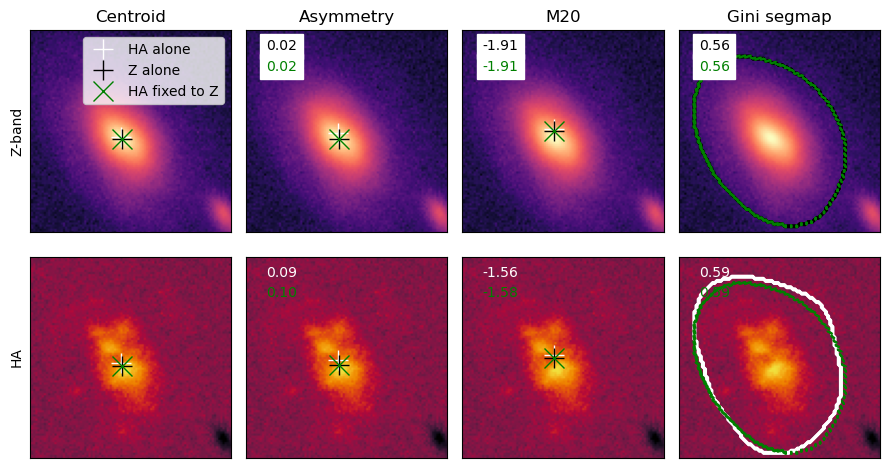

In [8]:
compare_morphs(morph_z, morph_ha, morph_joint, zoom = 100)

# Now look at all the examples

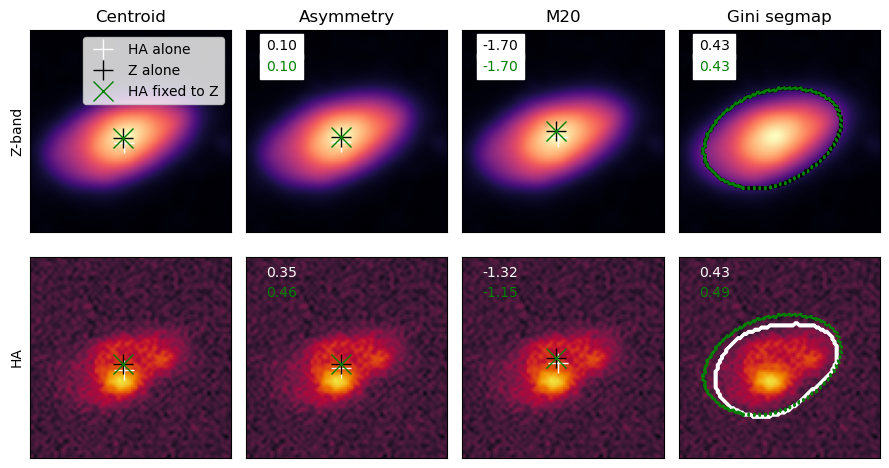

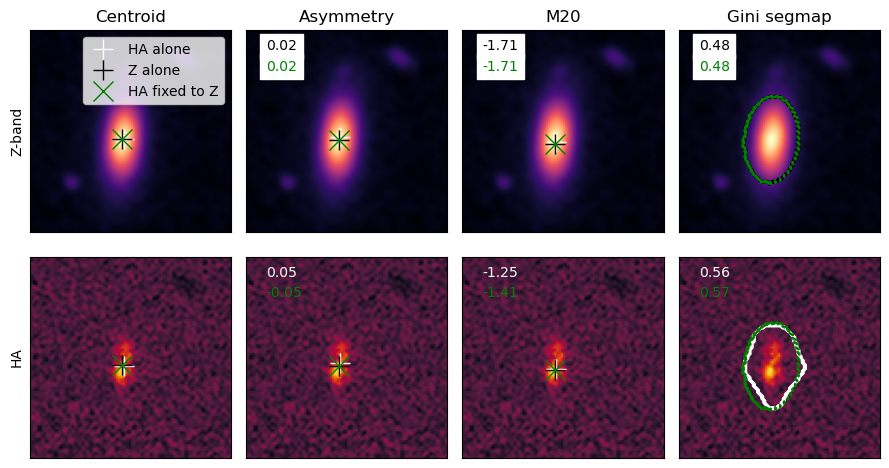

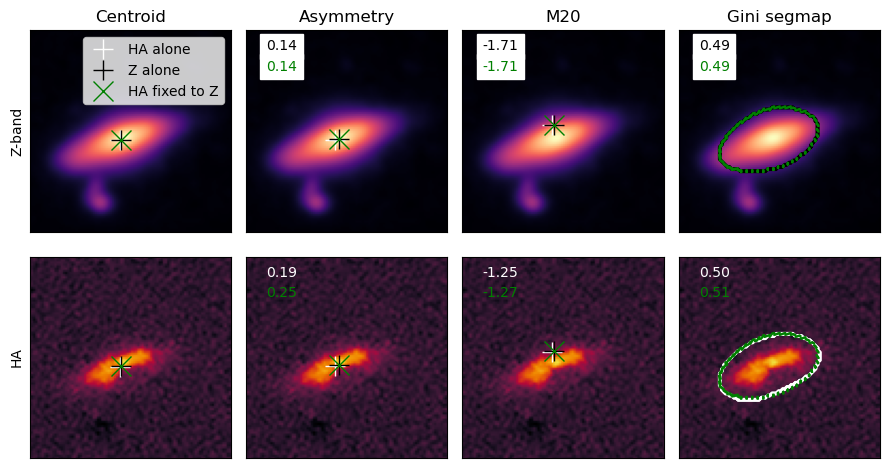

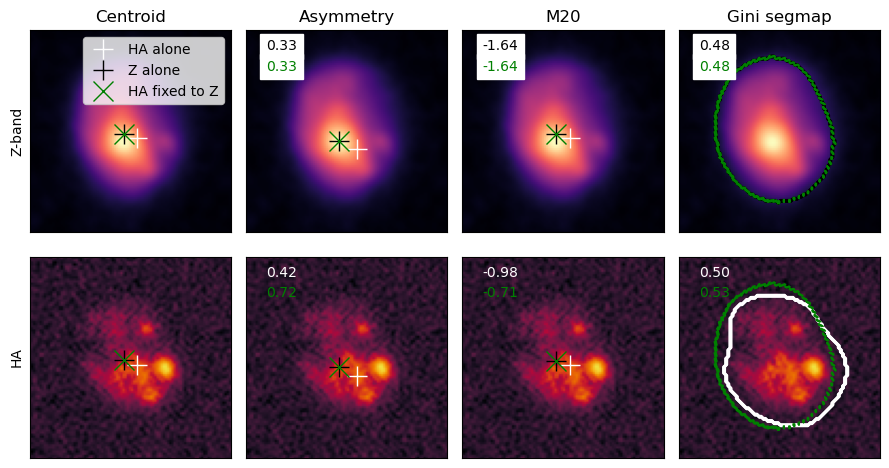

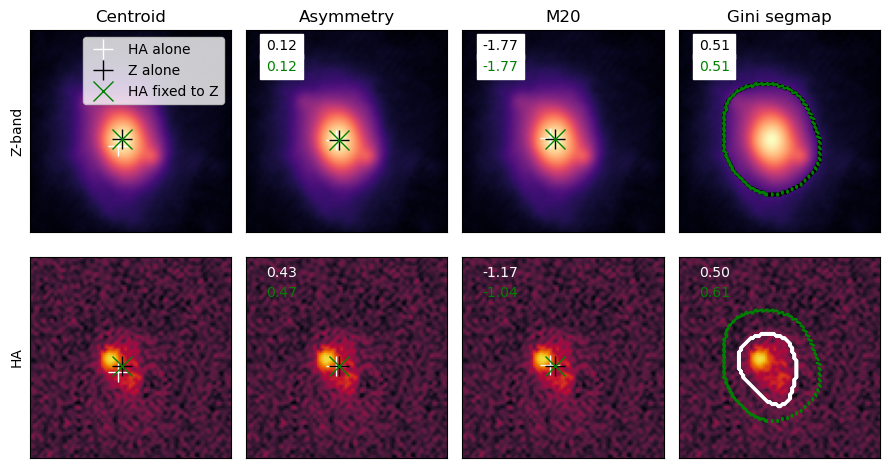

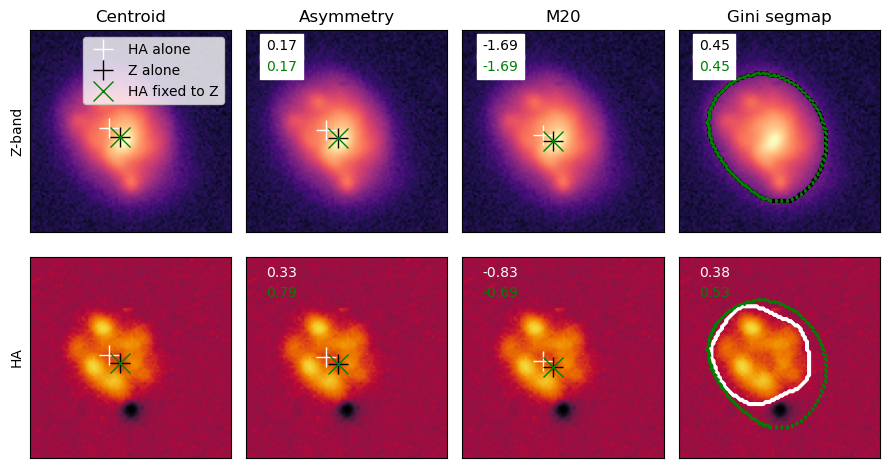

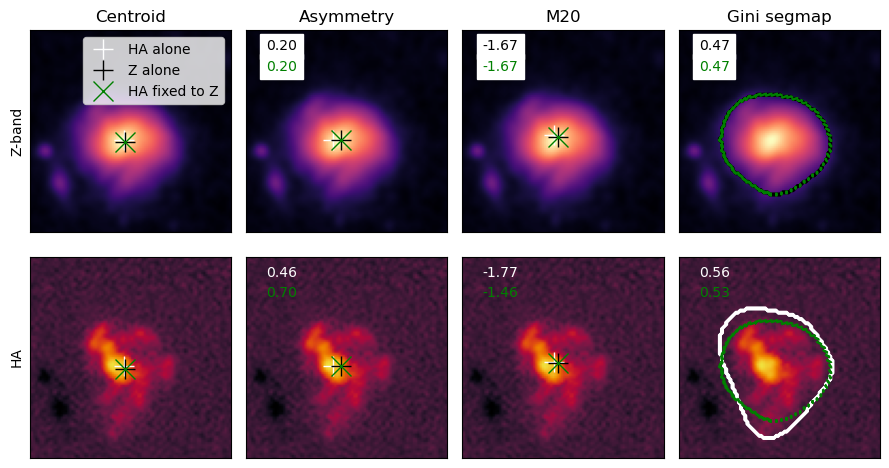

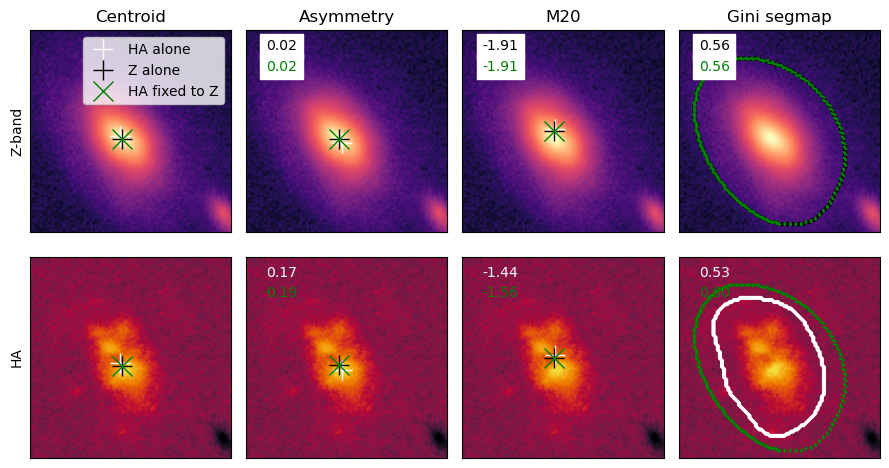

In [ ]:
for merid in merids:
    # open images
    image_ha = fits.open(f"example_images/{merid}_ha.fits")[1].data
    image_z  = fits.open(f"example_images/{merid}_z.fits")[1].data
    psf      = fits.open(f"example_images/{merid}_psf.fits")[0].data

    var_ha = fits.open(f"example_images/{merid}_ha.fits")[2].data
    var_z = fits.open(f"example_images/{merid}_z.fits")[2].data

    # get segmap and backgrounds
    segmap, mask = get_segmap(image_z, psf)
    ha_bkg = sep.Background(image_ha.astype(image_ha.dtype.newbyteorder('='))) # weird byteswap issue
    z_bkg = sep.Background(image_z.astype(image_z.dtype.newbyteorder('=')))

    # calculate morphologies
    morph_z = statmorph_joint.source_morphology(image_z - z_bkg, segmap, weightmap=var_z**.5, mask = mask)[0]
    morph_ha = statmorph_joint.source_morphology(image_ha - ha_bkg, segmap, weightmap=var_ha**.5, mask = mask)[0]
    morph_joint = statmorph_joint.source_morphology_joint([image_z - z_bkg, image_ha - ha_bkg], segmap, weightmaps=[var_z**.5, var_ha**.5], mask = mask)

    # plot comparison
    compare_morphs(morph_z, morph_ha, morph_joint, zoom = 100)